# Pathfinder tests

The goal of this module is to test the functionality of the pathfinder modules using the pre-saved data from the fullscan pathfinder.

In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import json
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator
from logging.handlers import RotatingFileHandler
from logging import Formatter

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..\\')
from Pathfinders import *

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [2]:
def logger_setup() -> logging.Logger:
    date_time_str = time.strftime(r"%Y-%m-%d_%H-%M-%S")

    # Configure the root logger to a particular folder, format, and level.
    # Lower the level when things are working better or worse.
    root_logger = logging.getLogger()
    path = os.path.dirname('..\\')
    
    handler = RotatingFileHandler(filename=path+f"\\logging\\runtime_test.log",
        backupCount=8,encoding="utf-8")
    handler.doRollover()

    formatter = Formatter(fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)
    root_logger.setLevel(logging.DEBUG)
    logger = logging.getLogger(__name__)
    logger.info("Debug log for the robot starting on " + date_time_str)
    return logger

# logger = logger_setup()

### Unload the data from a particular scan
This should only include data from a Fullscan module

In [3]:
path = os.path.abspath('..\\')
test_no = 6
# current_file = r"\Debugging Scripts\Scans\test_%s.json" % test_no
current_file = r"\Scans\test_%s.json" % test_no

debug_mode = True

### JSON Unpacking
Using the above file number and path, the scan data is unpacked from the corresponding JSON file. Unpacking the data can take around ~15 seconds depending on the length of the file, so a #TODO item is to create code for running a pathfinder directly off a math equation.

In [4]:
with open(path + current_file, 'r') as infile:
    json_data = json.load(infile)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
scan_max = np.array(json_data["max_point"])

# indices = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
# points = np.array([[p[0][indices[a][0]][indices[a][1]] for a in active_rom] for p in point_mags])
# mags = np.array([p[1] for p in point_mags])

points = np.array(point_mags)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
cols.append("mag")

data = pd.DataFrame(data=points, columns=cols)

points = data[active_rom]
mags = data['mag']
mp = data.loc[data['mag'].idxmax()]

In [5]:
print(points.shape)
print(mags.shape)
linInter = LinearNDInterpolator(points,mags,fill_value=-1)

r = dict()
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(point_mags[0])
    print(type(point_mags))
    print(r_o_m)
    print(np.shape(points))
    print(r)
    print(resolution)
# Usually takes about 25 seconds for test_6

(51749, 3)
(51749,)
Active range of motion: ['Z', 'Rx', 'Ry']
[-14.0, -13.0, -12.0, 216.071]
<class 'list'>
{'X': [0, 0], 'Y': [0, 0], 'Z': [-14, 14], 'Rx': [-13, 13], 'Ry': [-13, 13], 'Rz': [0, 0]}
(51749, 3)
{'X': 0.0, 'Y': 0.0, 'Z': 14.0, 'Rx': 13.0, 'Ry': 13.0, 'Rz': 0.0}
[0.4, 1]


In [6]:
# scanner = Discrete_degree(r['Z'], r['Rx'], r['Ry'])
# scanner = DivisionDiscreteDegree(4, r['Z'], r['Rx'], r['Ry'], cutoff_mag=50)
ex = 2
scanner = GradientAscent(r['Z']*ex,r['Rx']*ex,r['Ry']*ex,
        bias=5,steps=4,traverse=1.6,inc=0.75)

p = scanner.next()
i = 0

offset = np.array([0,0,-2,-5,5,0])

while type(p) is not int and i < 2500:
    i += 1
    # print(p)

    request = p + offset
    request = request[scanner.save_indices[0:-1]]
    # print(f"Request:\t\t\t{p}")
    mag = linInter(request)

    if mag == -1:
        mag = i * -20
    # print(f"magnitudes:{mag}")
    # print(f"Value pushed:\t\t\t{np.append(p,mag)}")

    scanner.newMag(np.append(p,mag))
    print(f"Mag: {mag}\t\tpoint:\t{np.append(p,mag)},\t\tLoop {i}                              ",end="\n")
    p = scanner.next()
    # print('\n'.join(prin), end=(len(prin) + 1)*'\033[F')

print()
print(p)
if debug_mode:
    print(f"Number of points to solve: {i}")
    # print(path + output_file)

point_mags_2 = scanner.points
search_max = scanner.max_point
active_rom = scanner.active_rom

cols = active_rom.copy()
cols.append("mag")

print(len(point_mags_2))

scanner_dat = np.array(scanner.points)

scanner_data = pd.DataFrame(data=scanner_dat, columns=cols)

print(scanner_data.head())
a = np.array(point_mags_2[0])
distance = 0

for i in range(1, len(point_mags_2)):
    b = np.array(point_mags_2[i])
    t = np.sum((b - a)**2)

    distance += t**0.5
    a = b

# (x,y,z,Rx,Ry,Rz,mag) = search_max.tolist()
# search_max = (((x+offset['X'],y+offset['Y'],z+offset['Z']),(Rx+offset['Rx'],Ry+offset['Ry'],Rz+offset['Rz'])),mag)
search_max = search_max + np.append(offset.copy(),0)

t = np.sum((scan_max[:3] - search_max[:3])**2)
lin_dist = t**0.5

degree_dist = np.arccos(np.cos(np.deg2rad(scan_max[3] - search_max[3])) 
            * np.cos(np.deg2rad(scan_max[4] - search_max[4])))

print("Pathfinder evalutation: ")
print(f"\tTotal search-space distance traveled: {distance}")
print(f"\tScan max value:\t\t{scan_max}")
print(f"\tSearch max value:\t{search_max}")
print(f"\tOffsets: {offset}")
print(f"\tDistance from target to found value: {lin_dist} mm, {degree_dist} deg")

Mag: [ 69.430]		point:	[ 0.000  0.000  0.000  0.000  0.000  0.000  69.430],		Loop 1                              
Mag: [ 69.430]		point:	[ 0.000  0.000  0.000  0.000  0.000  0.000  69.430],		Loop 2                              
Mag: [ 88.871]		point:	[ 0.000  0.000  0.562  0.000  0.000  0.000  88.871],		Loop 3                              
Mag: [ 72.434]		point:	[ 0.000  0.000 -0.562  0.000  0.000  0.000  72.434],		Loop 4                              
Mag: [ 81.007]		point:	[ 0.000  0.000  0.000  1.125  0.000  0.000  81.007],		Loop 5                              
Mag: [ 66.092]		point:	[ 0.000  0.000  0.000 -1.125  0.000  0.000  66.092],		Loop 6                              
Mag: [ 67.923]		point:	[ 0.000  0.000  0.000  0.000  1.125  0.000  67.923],		Loop 7                              
Mag: [ 63.955]		point:	[ 0.000  0.000  0.000  0.000 -1.125  0.000  63.955],		Loop 8                              
Mag: [ 60.711]		point:	[ 0.000  0.000 -0.875 -0.794 -0.211  0.000  60.711],		Loop 9     

(-3.1752630850102124, 7.93815771252553)
(-4.0946816807312505, 3.73249911720811)
(-3.4991945779648845, 8.747986444912213)


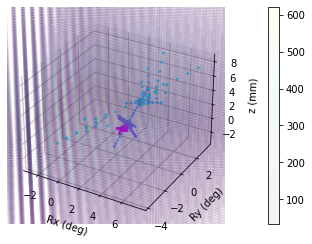

In [7]:
ax = plt.axes(projection='3d')
fig = ax.scatter(data['Rx'], data['Ry'], data['Z'], c=data['mag'], cmap='viridis', alpha=0.05, linewidth=0.02)
plt.colorbar(fig, pad=0.13,alpha=1)

# fig = ax.scatter(Rxs1, Rys1, Zs1, c=range(len(Zs1)), cmap='binary', alpha=0.8, linewidth=0.8, s=4)
fig = ax.scatter(scanner_data['Rx'], scanner_data['Ry'], scanner_data['Z'], c=range(len(scanner_data)), cmap='cool', alpha=0.8, linewidth=0.8, s=4)

ax.set_xlabel("Rx (deg)")
ax.set_ylabel("Ry (deg)")
ax.set_zlabel("z (mm)")
plt.rcParams['figure.dpi'] = 200

print((min(scanner_data['Rx']),max(scanner_data['Rx'])))
print((min(scanner_data['Ry']),max(scanner_data['Ry'])))
print((min(scanner_data['Z']),max(scanner_data['Z'])))

ax.set_xbound((min(scanner_data['Rx']),max(scanner_data['Rx'])))
ax.set_ybound((min(scanner_data['Ry']),max(scanner_data['Ry'])))
ax.set_zbound((min(scanner_data['Z']),max(scanner_data['Z'])))

# plt.savefig("fullscan_render.jpg", dpi=400)
plt.show()
# plt.axes(projection = "3d")
# plt.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.8, linewidth=0.5)


In [8]:
# I want to check the optimal values for traverse distance, increment size, bias, and steps. This is gonna be rough.
(trav_min, trav_max, trav_step) = (0.8,2.4,4)
(inc_min, inc_max, inc_step) = (1.4,2.2,4)
(bias_min,bias_max,bias_step) = (0,18,4)
(step_min,step_max,step_step) = (1,7,4)

# var_comparison = pd.DataFrame(columns = ['Traverse','Increment', 'bias','step',
#     'Points_visited','final_max','max_mag'])

test_vars = np.mgrid[
    trav_min:trav_max:trav_step*1j,
    inc_min:inc_max:inc_step*1j,
    bias_min:bias_max:bias_step*1j,
    step_min:step_max:step_step*1j].reshape(4,-1).T

(z0,z1,zs) = (-2.4,7.0,3)
(Rx0,Rx1,Rxs) = (-13,13,3)
(Ry0,Ry1,Rys) = (-13,13,3)

offsets = np.mgrid[0:0:1j,
                    0:0:1j,
                    z0:z1:zs*1j,
                    Rx0:Rx1:Rxs*1j,
                    Ry0:Ry1:Rys*1j,
                    0:0:1j].reshape(6,-1).T

# offset = np.array([0,0,-3,-10,12,0])

print(test_vars.shape[0] * offsets.shape[0])

6912


In [9]:
# vc = pd.DataFrame(columns = ['offset','Traverse','Increment', 'bias','step',
#     'Points_visited','final_max','max_mag'])

# tot = test_vars.shape[0] * offsets.shape[0]

# i = 0
# for test_set in test_vars:
#     for offset in offsets:
#         start_time = time.time()
#         traverse=test_set[0]
#         inc=test_set[1]
#         bias=int(test_set[2])
#         step=int(test_set[3])

#         test = GradientAscent(r['Z']*ex,r['Rx']*ex,r['Ry']*ex,
#             bias=bias,steps=step,traverse=traverse,inc=inc)

#         p = test.next()
#         j=0
#         while type(p) is not int and j < 2000:
#             j += 1

#             request = p + offset
#             request = request[test.save_indices[0:-1]]
#             # print(f"Reuqest: {request}")
#             mag = linInter(request)

#             if mag[0] == -1:
#                 mag[0] = i * -20
#             # print(f"magnitudes:{mag}")
#             # print(f"Value pushed: {np.append(p,mag[0])}")

#             test.newMag(np.append(p,mag[0]),True)
#             p = test.next()
#             if j % 50 == 0:
#                 print(f"Highest magnitude: {test.max_point[6]}\tLoop {j}\t\t\t",end="\r")
#             if type(p) is int:
#                 j = 2500
#         i+=1
#         vc.loc[len(vc.index)] = (offset,traverse,inc,bias,step,j,test.max_point,test.max_point[6])
#         print(f"Test ({i}/{tot}):({offset[test.save_indices[0:-1]]}),\ttrav={traverse:0.1f}\tinc={inc}\tbias={bias}\tstep={step}"
#             f"\tcompleted in {(time.time() - start_time):0.2f} seconds.\tMax mag found {test.max_point[6]:0.2f}")


In [10]:
# print(vc.head())
# print(vc.tail())

path = os.path.abspath('..\\')
# test_no = 6
# current_file = r"\Debugging Scripts\Scans\test_%s.json" % test_no
current_file = path + r"\parameter_check2.csv"
print(current_file)

# vc.to_csv(current_file)

c:\Users\ander\OneDrive - UW\Robotics lab material\Robotics Control Code\Ben's Control Code\parameter_check2.csv


In [11]:
param_dat = pd.read_csv(current_file)
# print(param_dat.columns)
param_dat = param_dat.drop('Unnamed: 0',axis=1)

# print(param_dat.head())

succ = param_dat[param_dat['max_mag'] > 600].reset_index(drop=True)
max = succ.loc[succ['max_mag'].idxmax()]

# print(succ[succ['Points_visited'] < 2000].reset_index(drop=True))
print(max)
# print(succ.to_string())
combos = succ[['bias','step','Traverse','Increment']].value_counts().reset_index(name='count')
combos.drop('count', axis=1, inplace=True)
print(combos.head())

row = combos.loc[[4]].values[0].tolist()
print(row)
# bias,step,trav,inc = row['bias'].values,row['step'],row['Traverse'],row['Increment']
bias,step,trav,inc = row

print()
averages = []


# print(combos.shape)
# print(combos.loc[[2]])
for i in range(combos.shape[0]):
    row = combos.loc[[i]].values[0].tolist()
    bias,step,trav,inc = row
    averages.append(np.mean(succ[np.all([succ['bias']==bias,
        succ['step']==step,succ['Traverse']==trav,
        succ['Increment']==inc],axis=0)]
        .reset_index(drop=True)['max_mag']))

combos['avg'] = averages
print(combos.head())
combos.sort_values('avg',axis=0,inplace=True,ascending=False)
print(combos.to_string())    

    

FileNotFoundError: [Errno 2] No such file or directory: "c:\\Users\\ander\\OneDrive - UW\\Robotics lab material\\Robotics Control Code\\Ben's Control Code\\parameter_check2.csv"

In [ ]:
a = []
for i in range(10):
    a.append(np.array([0,0,i]))

a = np.array(a)
print(a)

[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 0 4]
 [0 0 5]
 [0 0 6]
 [0 0 7]
 [0 0 8]
 [0 0 9]]


In [14]:
A = np.eye(4)
A = np.diag([4,3,2,1])
b = np.array([1,2,3,4])

print(b.T@A@b)
print(A@b@b)

50
50
